In [ ]:
!pip install transformers
!pip install scipy
!pip install torch torchvision 
!pip install matplotlib
# Runtime might need restarting after this installation.
!pip install tdqm
!pip install twitscrape
# twitscrape is a package I created as an aside to this project to further bolster my learning (https://github.com/christywastaken/twitscrape, https://pypi.org/project/twitscrape). 
# I'm sure there are more effective ways of collecting the tweet data used in this project. If you are looking to repeat this data analysis I would reccomend looking for another package such as snscrape.


import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [12]:
import pandas as pd
import re

def clean_tweets(tweet_df: pd.DataFrame) -> pd.DataFrame:
    cleaned_tweet_df = tweet_df.copy()
    for index, row in cleaned_tweet_df.iterrows():
        tweet_text = row['tweet_text']
        clean_tweet_text = re.sub("@[A-Za-z0-9_]+","", tweet_text)
        #TODO: Should I replace @mentions with a name like 'Daniel' to help the sentiment analysis? Or should I include @mentions as original? test this.
        clean_tweet_text = re.sub("#[A-Za-z0-9_]+","", clean_tweet_text)
        clean_tweet_text = clean_tweet_text.lower()
        print(f'\ntweet: {tweet_text}\nclean: {clean_tweet_text}\n')
        
        cleaned_tweet_df.at[index, 'cleaned_tweet_text'] = clean_tweet_text
    
    return cleaned_tweet_df


In [5]:
import sqlite3

class SQLContextManager():
    """ Context manager for SQL db """
    def __init__(self, host):
        self.connection = None
        self.host = host

    def __enter__(self):
        self.connection = sqlite3.connect(self.host)
        return self.connection
        
    def __exit__(self, exc_type, exc_val, exc_tab):
        self.connection.commit()
        self.connection.close()
        
        

In [61]:
import pandas as pd
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
import numpy as np
from tqdm.auto import tqdm




#TODO: Check licensing and citing for https://github.com/cardiffnlp/timelms 
#TODO: consider saving model to local.

class SentimentAnalysis():
    
    def __init__(self):
        self.MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
        self.tokenizer = AutoTokenizer.from_pretrained(self.MODEL)
        self.config = AutoConfig.from_pretrained(self.MODEL)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.MODEL)


    def preprocess(self, text):
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        return " ".join(new_text)


    def analyse_sentiment(self, tweet_df: pd.DataFrame) -> pd.DataFrame:
        """ Analyses the sentiment of tweets and returns a dataframe with new columns 'negative', 'neutral' and 'positive' """
        tweet_df_copy = tweet_df.copy()
        # model.save_pretrained(MODEL) #TODO: consider saving to local
        for index, row in tqdm(tweet_df_copy.iterrows()):
            try:
                tweet_text = row['tweet_text']
                tweet_text = self.preprocess(tweet_text)
                encoded_input = self.tokenizer(tweet_text, return_tensors='pt')
                output = self.model(**encoded_input)
                scores = output[0][0].detach().numpy()
                scores = softmax(scores)
                scores = np.round(scores.astype(float), 4)
                sentiment_dict = {self.config.id2label[i]: score for i, score in enumerate(scores)}
                for column, value in sentiment_dict.items():
                    tweet_df_copy.at[index, column] = value
                # print(f'tweet: {tweet_text} | senti: {sentiment_dict}')
            except Exception as err:
                print(f'Error at index:{index} | Error: {err}')
        return tweet_df_copy


    def analyse_sentiment_row(self, tweet_text: str) -> list[float, float, float]:
        try:
            tweet_text = self.preprocess(tweet_text)
            encoded_input = self.tokenizer(tweet_text, return_tensors='pt')
            output = self.model(**encoded_input)
            scores = output[0][0].detach().numpy()
            scores = softmax(scores)
            scores = np.round(scores.astype(float), 4)
        except Exception as err:
            print(f'Error: {err}')
            return [None, None, None]

    


In [62]:
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT * FROM summer_solstice_week"
    test_tweet_df = pd.read_sql(query, connection)
    analyse_sentiment = SentimentAnalysis().analyse_sentiment_row
    tqdm.pandas(desc="Analysing sentiment of tweet_text column")
    test_tweet_df['negative', 'neutral', 'positive'] = test_tweet_df['tweet_text'].progress_apply(analyse_sentiment)
    test_tweet_df.to_sql('test_table_apply_method', con=connection, if_exists='replace')
    


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Analysing sentiment of tweet_text column: 100%|██████████| 958/958 [02:22<00:00,  6.73it/s]


In [63]:
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT * FROM summer_solstice_week"
    test_tweet_df = pd.read_sql(query, connection)
    analyse_sentiment = SentimentAnalysis().analyse_sentiment
    test_tweet_df = analyse_sentiment(test_tweet_df)
    test_tweet_df.to_sql('test_table_apply_method', con=connection, if_exists='replace')

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
958it [02:21,  6.77it/s]


In [28]:
import pandas as pd
from datetime import datetime

def add_epoch_time_and_sort(tweet_df: pd.DataFrame) -> pd.DataFrame:
    """ Adds epoch_seconds column to df and sorts by epoch_seconds ascending """
    
    tweet_df_copy = tweet_df.copy()
    date_format = "%a %b %d %H:%M:%S %z %Y"

    for index, row in tweet_df_copy.iterrows():
        try:
            created_at = row['created_at']
            epoch_seconds = datetime.strptime(created_at, date_format).timestamp()
            tweet_df_copy.at[index, 'epoch_seconds'] = epoch_seconds
        except Exception as err:
            print(f'Error: {err}')
    tweet_df_copy.sort_values(by='epoch_seconds', inplace=True, ignore_index=True)
    tweet_df_copy.reset_index(inplace=True, drop=True)
    return tweet_df_copy


In [ ]:
# Testing whether data is missing
from datetime import datetime
import pandas as pd

def check_gaps_in_data(tweet_df: pd.DataFrame) -> pd.DataFrame:
    """ Adds time_diff_mins coloumn to df which can be used for identifying holes in data. This column is the time betweent the current and next tweet """
    tweet_df_copy = tweet_df.copy()
    
    largest_time_diff = 0.0
    index_largest_diff = 0
    for index, row in tweet_df_copy.iterrows():
        try:
            epoch_seconds1 = tweet_df_copy.iloc[index]['epoch_seconds']
            epoch_seconds2 = tweet_df_copy.iloc[index+1]['epoch_seconds']
            
            time_diff = epoch_seconds2 - epoch_seconds1
            time_diff_mins = round((time_diff / 60), 2)
            if time_diff_mins > largest_time_diff:
                largest_time_diff = time_diff_mins
                index_largest_diff = index
            tweet_df_copy.at[index, 'time_diff_mins'] = time_diff_mins
            

        except Exception as err:
            print(f'Error: {err}')
    print(f'-- The largest gap in data is: {largest_time_diff} mins at index: {index_largest_diff} --')
    return tweet_df_copy






In [ ]:
import sqlite3
from twitscrape.twitter_scraper import TwitterGeolocationScraper 
# twitscrape is a package I built and distributed as an aside learning experiment to this project. I plan to work on it further so the import method might change from the above.
# https://github.com/christywastaken/twitscrape 
# https://pypi.org/project/twitscrape/ 

newcastle_latitude = 54.975029
newcastle_longitude = -1.612477
search_radius_km = 15.0
twitter_scraper = TwitterGeolocationScraper(start_date='2022-01-01', end_date='2023-01-01', latitude=newcastle_latitude, longitude=newcastle_longitude, radius=search_radius_km, filter_links=True, filter_replies=True, is_headless=True)
tweet_df = twitter_scraper.run()
# Creates dataframe of all the tweets in Newcastle-Upon-Tyne for a 15km radius for all of 2022. No replies or tweets containing media included.

#Store DF to SQL DB
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    tweet_df.to_sql('all_2022', connection, if_exists='replace', index=False)




In [31]:
# Add epoch_seconds to SQL db.
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT * FROM all_2022"
    tweet_df = pd.read_sql(query, connection)
    epoc_tweet_df = add_epoch_time_and_sort(tweet_df=tweet_df)
    epoc_tweet_df.to_sql('all_2022', con=connection, if_exists='replace', index=False)





In [34]:
# check for gaps in data and sort by largest gaps.
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT * FROM all_2022"
    tweet_df = pd.read_sql(query, connection)

tweet_df_time_gaps = check_gaps_in_data(tweet_df)
tweet_df_time_gaps.sort_values(by='time_diff_mins', inplace=True, ascending=False)




Error: single positional indexer is out-of-bounds
-- The largest gap in data is: 556.58 mins at index: 30882 --


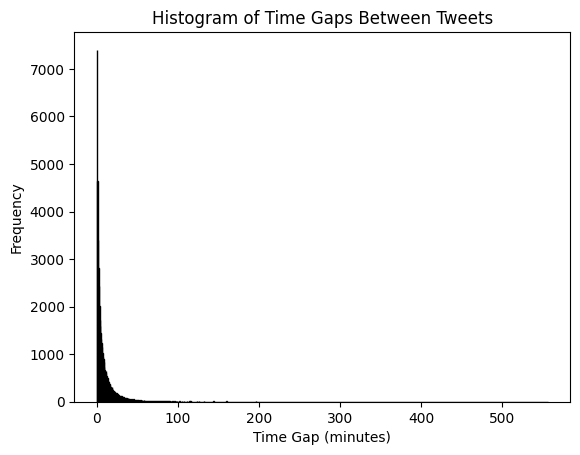

In [38]:
# visiualizing gaps in the data 
import matplotlib.pyplot as plt

plt.hist(tweet_df_time_gaps['time_diff_mins'], bins='auto', edgecolor='black')
plt.title('Histogram of Time Gaps Between Tweets')
plt.xlabel('Time Gap (minutes)')
plt.ylabel('Frequency')
plt.show()

In [44]:
# Getting some numbers on the gaps in the data
data_size = len(tweet_df_time_gaps)
for time in [60,120,360,420,480]:
    num_gaps = sum(tweet_df_time_gaps['time_diff_mins']>time)
    print(f'Percentage of tweets with gap >{str(time)} mins: {round(((num_gaps/data_size)*100),4)}%')





Percentage of tweets with gap >60 mins: 2.2118%
Percentage of tweets with gap >120 mins: 0.7333%
Percentage of tweets with gap >360 mins: 0.0198%
Percentage of tweets with gap >420 mins: 0.004%
Percentage of tweets with gap >480 mins: 0.002%


In [50]:
# analyse the sentiment of the data. 
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT * FROM all_2022"
    tweet_df = pd.read_sql(query, connection)

sentiment_tweet_df = analyse_sentiment(tweet_df)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
653it [01:26,  8.10it/s]

Error: The expanded size of the tensor (535) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 535].  Tensor sizes: [1, 514]


1316it [03:00,  7.28it/s]


KeyboardInterrupt: 